In [76]:
import numpy as np
from typing import Tuple
from scipy.integrate import quad
from scipy.special import erfc
from util import *
from data_model import *
from scipy.optimize import root_scalar


Test on whether the moreau envelope value changes if you add an arbitrary epsilon vs if you don't


In [77]:
"""
Proximal from root scalar logistic
"""
def optim(z,y,V,w_prime):
    a = y*z
    if a <= 0:
        return y*V/(1+ np.exp(y*z)) + w_prime - z
    else:
        return y*V*np.exp(-y*z)/(1+ np.exp(-y*z)) + w_prime - z

def proximal_logistic_root_scalar(V: float, y: float, epsilon_term: float, w:float) -> float:
    if y == 0:
        return w
    try:
        w_prime = w - epsilon_term / y
        result = root_scalar(lambda z: optim(z,y,V,w_prime) , bracket=[-50000000,50000000],xtol=10e-10,rtol=10e-10)
        z = result.root
        return z + epsilon_term / y
    except Exception as e:
        # print all parameters
        print("V: ", V, "y: ", y, "epsilon_term:", epsilon_term, "w: ", w)
        raise e

def log1pexp(x):
    """Compute log(1+exp(x)) componentwise."""
    # inspired from sklearn and https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf
    # and http://fa.bianp.net/blog/2019/evaluate_logistic/
    out = np.zeros_like(x)
    idx0 = x <= -37
    out[idx0] = np.exp(x[idx0])
    idx1 = (x > -37) & (x <= -2)
    out[idx1] = np.log1p(np.exp(x[idx1]))
    idx2 = (x > -2) & (x <= 18)
    out[idx2] = np.log(1. + np.exp(x[idx2]))
    idx3 = (x > 18) & (x <= 33.3)
    out[idx3] = np.exp(-x[idx3]) + x[idx3]
    idx4 = x > 33.3
    out[idx4] = x[idx4]
    return out

def adversarial_loss(y,z, epsilon_term):
    return log1pexp(-y*z + epsilon_term)


def moreau_envelope(sigma: float, z:float, y: float, epsilon_term: float, w: float) -> float:
    return adversarial_loss(y,z,epsilon_term) + ((z-w)**2)/(2*sigma)



In [78]:

V = 1
y = 1
w = 1
for eps in np.linspace(0,1000,10):
    z = proximal_logistic_root_scalar(V,y,eps,w)
    print(z, moreau_envelope(V,y,z,eps,w))

1.2267506448342533 0.2571537013447093
1.9999999950000387 109.11111111611108
1.9999999950000529 220.22222222722218
1.9999999950001097 331.33333333833326
1.9999999950001097 442.44444444944435
1.9999999950001666 553.5555555605554
1.9999999950001666 664.6666666716666
1.9999999950002803 775.7777777827775
1.9999999950002803 886.8888888938886
1.9999999950002803 998.0000000049997


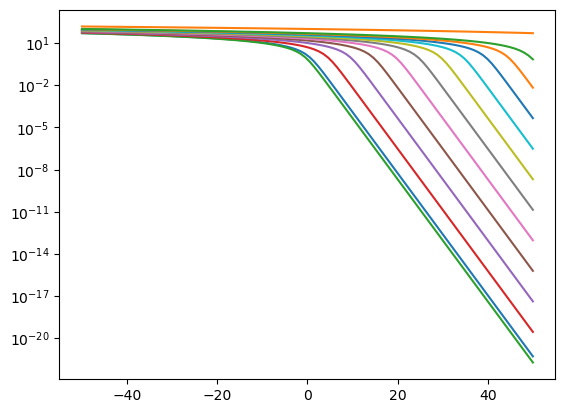

In [79]:
zs = np.linspace(-50,50,100)
moreaus_1 = [moreau_envelope(V,y,z,1,w) for z in zs]
# continue in steps of 5
moreaus_5 = [moreau_envelope(V,y,z,5,w) for z in zs]
moreaus_10 = [moreau_envelope(V,y,z,10,w) for z in zs]
moreaus_15 = [moreau_envelope(V,y,z,15,w) for z in zs]
moreaus_20 = [moreau_envelope(V,y,z,20,w) for z in zs]
moreaus_25 = [moreau_envelope(V,y,z,25,w) for z in zs]
moreaus_30 = [moreau_envelope(V,y,z,30,w) for z in zs]
moreaus_35 = [moreau_envelope(V,y,z,35,w) for z in zs]
moreaus_40 = [moreau_envelope(V,y,z,40,w) for z in zs]
moreaus_45 = [moreau_envelope(V,y,z,45,w) for z in zs]
moreaus_50 = [moreau_envelope(V,y,z,50,w) for z in zs]
moreaus_100 = [moreau_envelope(V,y,z,100,w) for z in zs]
moreaus_0 = [moreau_envelope(V,y,z,0,w) for z in zs]

import matplotlib.pyplot as plt
# plot with legends
plt.plot(zs, moreaus_1, label='epsilon=1')
plt.plot(zs, moreaus_100, label='epsilon=100')
plt.plot(zs, moreaus_0, label='epsilon=0')
plt.plot(zs, moreaus_5, label='epsilon=5')
plt.plot(zs, moreaus_10, label='epsilon=10')
plt.plot(zs, moreaus_15, label='epsilon=15')
plt.plot(zs, moreaus_20, label='epsilon=20')
plt.plot(zs, moreaus_25, label='epsilon=25')
plt.plot(zs, moreaus_30, label='epsilon=30')
plt.plot(zs, moreaus_35, label='epsilon=35')
plt.plot(zs, moreaus_40, label='epsilon=40')
plt.plot(zs, moreaus_45, label='epsilon=45')
plt.plot(zs, moreaus_50, label='epsilon=50')
plt.yscale('log')
# plt.legend()
plt.show()


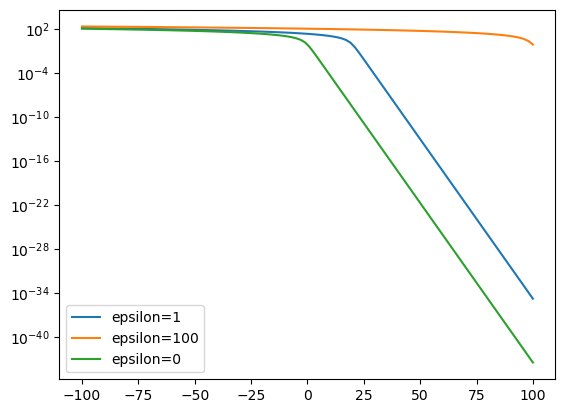

In [80]:
zs = np.linspace(-100,100,100)
loss_20 = [adversarial_loss(y,z,20) for z in zs]
loss_100 = [adversarial_loss(y,z,100) for z in zs]
loss_0 = [adversarial_loss(y,z,0) for z in zs]

# plot with legends
plt.plot(zs, loss_20, label='epsilon=1')
plt.plot(zs, loss_100, label='epsilon=100')
plt.plot(zs, loss_0, label='epsilon=0')
# y log scale
plt.yscale('log')
plt.legend()
plt.show()


So as we can see, indeed the place where the minimum is located converges quickly, but not the value of the minimum. As epsilon to infinity, the value approaches epsilon. We want to know how the value of the minimum changes as a function of epsilon

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_35932/4092065641.py:56: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(eps, numpy_gradient/eps, label='numpy gradient')


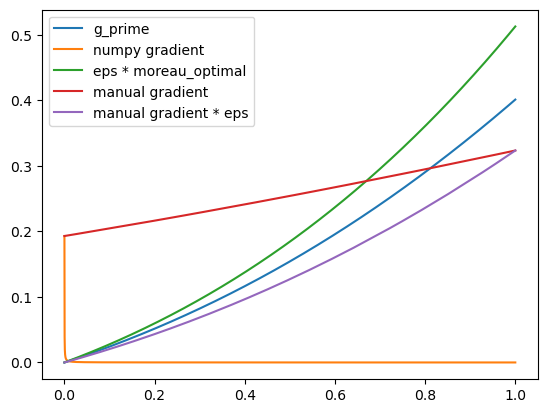

In [85]:


def stable_sigmoid(x):
    # if the argument is no numpy array, make it one
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    out = np.zeros_like(x)
    idx = x <= 0
    out[idx] = np.exp(x[idx]) / (1 + np.exp(x[idx]))
    idx = x > 0
    out[idx] = 1 / (1 + np.exp(-x[idx]))
    return out

def g_prime_derivative(V,y,e,w):
    z = proximal_logistic_root_scalar(V,y,e,w)
    return stable_sigmoid(-y*z + e)*e

def moreau_envelope_for_gradient(V,y,Deltaepsilon,w):
    # if epsilon is a numpy array or a mg tensor do this, otherwise only for one epsilon
    if isinstance(Deltaepsilon, np.ndarray) or isinstance(Deltaepsilon, mg.Tensor):
        zs = np.array([ proximal_logistic_root_scalar(V,y,e,w) for e in Deltaepsilon])
    else:
        zs = proximal_logistic_root_scalar(V,y,Deltaepsilon,w)
    return moreau_envelope(V,y,zs,Deltaepsilon,w)

def moreau_optimal(V, y, Deltaepsilon, w):
    z = proximal_logistic_root_scalar(V,y,Deltaepsilon,w)
    return moreau_envelope(V,y,z,Deltaepsilon,w)

import mygrad as mg
eps = np.linspace(0,1,1000)
eps_tensor = mg.tensor(eps)
f = moreau_envelope_for_gradient(V,y,eps_tensor,w)
f.backward()
mg_grad = f.grad

values_moreau = np.array([moreau_envelope_for_gradient(V,y,e,w) for e in eps])
numpy_gradient = np.gradient(values_moreau)

g_prime = np.array([g_prime_derivative(V,y,e,w) for e in eps])

eps_mor = np.array([e*moreau_optimal(V,y,e,w) for e in eps])

# Let's do a thing.
gradient_manual = []
for e in eps:
    diff = 0.0000000001
    plus = moreau_optimal(V,y,e+diff,w)
    minus = moreau_optimal(V,y,e-diff,w)
    gradient_manual.append((plus-minus)/(2*diff))

gradient_manual = np.array(gradient_manual)
gradient_manual_eps = gradient_manual * eps

# plot with legends
# plt.plot(eps, my_moreau, label='my moreau')
plt.plot(eps, g_prime, label='g_prime')
plt.plot(eps, numpy_gradient/eps, label='numpy gradient')
# plt.plot(eps, mg_grad, label='mygrad gradient')
plt.plot(eps, eps_mor, label='eps * moreau_optimal')
plt.plot(eps, gradient_manual, label='manual gradient')
plt.plot(eps, gradient_manual_eps, label='manual gradient * eps')

# y log scale
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()